In [60]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [182]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = make_classification(n_samples=500,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=1)

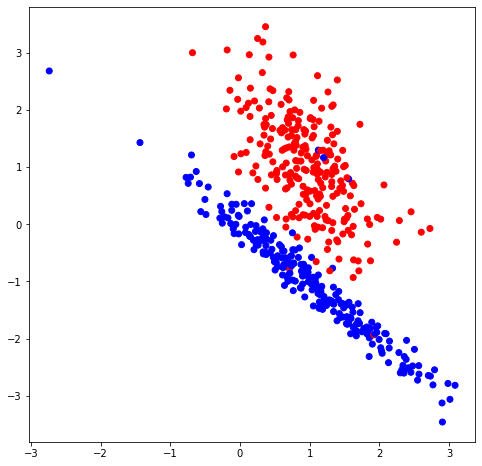

In [183]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [184]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    learn_table=np.zeros((n_samples,N), dtype=int) # Добавили матрицу-заготовку с формой соответств. кол-ву деревьев и объектов
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        learn_table[sample_index, i] = 1 # Присваиваем элементам матрицы 1 тем элементам, которые пойдут в обучение дерева
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap, learn_table


In [185]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [186]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [187]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [188]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [189]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [190]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [191]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [192]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [193]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, learn_table = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, learn_table

In [195]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [196]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [197]:
# предсказание голосованием деревьев

def tree_vote(forest, data, learn_table):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    # print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    # predictions_per_object = list(zip(*predictions))
    # print(predictions_per_object)
    predictions_per_object = []
    
    # Для каждого объекта определили голоса только тех деревьев, которые не обучались по данному объекту
    # И составили список предсказаний по объектам
    for i in range(data.shape[0]):
        ob = []
        predictions_per_object.append(ob)
        for k in range(len(forest)):
            if learn_table[i,k] == 0:
                predictions_per_object[i].append(predictions[k][i])   
    
    # print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        if len(obj) > 0:
            voted_predictions.append(max(set(obj), key=obj.count))
    # Если оказывается, что по объекту обучались все деревья - по нему нет предсказания
        else: 
            voted_predictions.append(None)
            
    return voted_predictions

In [198]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [199]:
# Введем функцию подсчета точности как доли правильных ответов
# Рассчет точности также скорректирован под ООВ

def accuracy_metric(actual, predicted):
    correct = 0
    num_act = len(actual)
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
            # Если по объекту нет предсказания мы сокращаем количество объектнов относительно которых считаем точность
            elif predicted[i] == None:
            num_act -= 1
    print(num_act, len(actual), correct)
    return correct / float(num_act) * 100.0

In [37]:
%%time
n_trees = 1
my_forest_1, lt_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 225 ms


In [38]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [39]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [40]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 98.286
Точность случайного леса из 1 деревьев на тестовой выборке: 92.667


In [174]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, forest, learn_table):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()], learn_table)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

<ipython-input-43-8e1170505b4d>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-43-8e1170505b4d>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


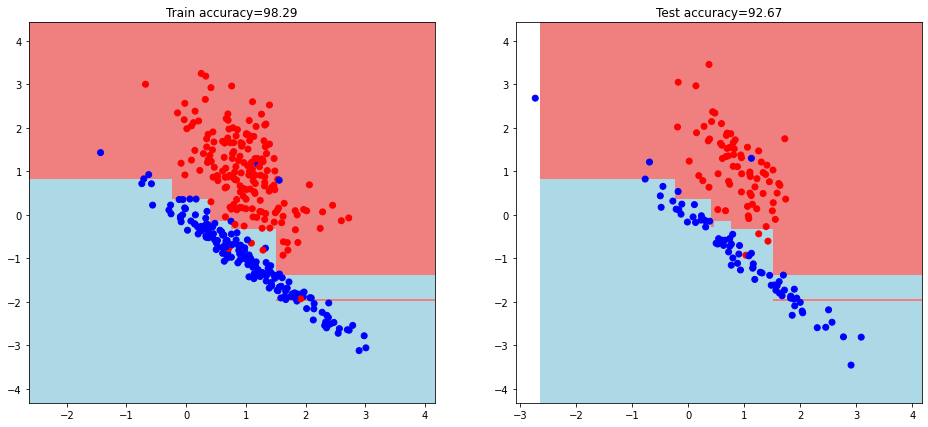

In [44]:
visualize(train_data, test_data, my_forest_1)

In [200]:
%%time
n_trees = 3
my_forest_3, lt_3 = random_forest(classification_data, classification_labels, n_trees)

Wall time: 903 ms


In [201]:
answers = tree_vote(my_forest_3, classification_data, lt_3)

In [202]:
# Точность на тестовой выборке
accuracy = accuracy_metric(classification_labels, answers)
print(f'Точность OOB случайного леса из {n_trees} деревьев : {accuracy:.3f}')

359 500 335
Точность OOB случайного леса из 3 деревьев : 93.315


In [49]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 2.2 s


In [50]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [51]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.143
Точность случайного леса из 10 деревьев на тестовой выборке: 98.000


<ipython-input-43-8e1170505b4d>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-43-8e1170505b4d>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


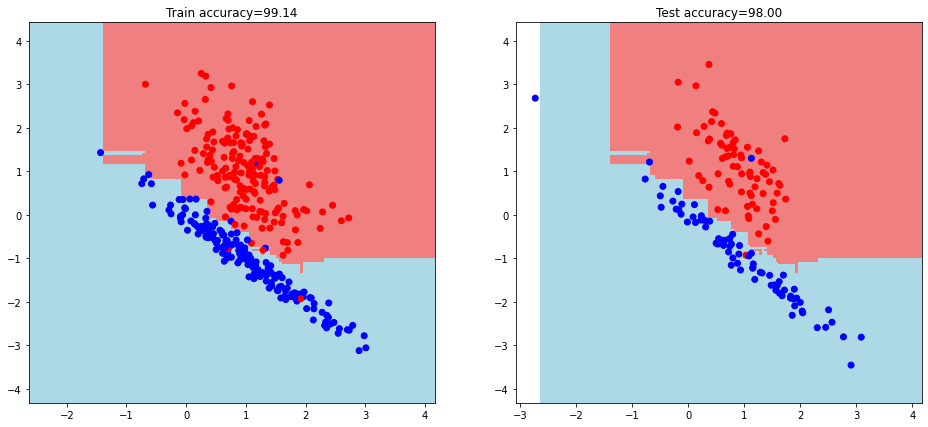

In [52]:
# Визуализация сделана до исправления функций под OOB
visualize(train_data, test_data, my_forest_10)

In [53]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

Wall time: 13 s


In [56]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [57]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 96.000


<ipython-input-43-8e1170505b4d>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-43-8e1170505b4d>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


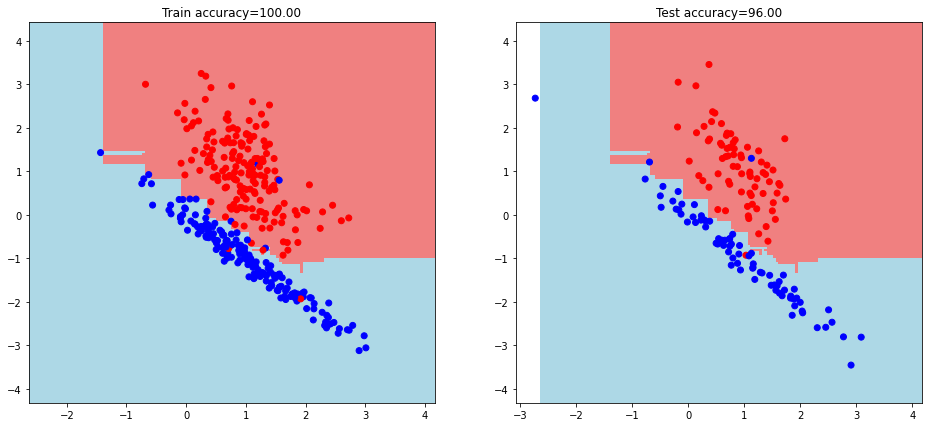

In [58]:
visualize(train_data, test_data, my_forest_10)

## 2
Сложность модели возрастает с увеличением количества деревьев в лесу.
На первых шагах - 3 дерева вместо 1. Видно, что модель пытается уловить выбросы - попадания одного класса в гущу другого.
Видно, что показатель точности на тестовой выборке 93.

С увеличением числа деревьев до 10 деревьев модель становится сложнее (если считать количество ступенек на плоскости).
И переобучение минимально.

С дальнейшим увеличением числа деревьев модель опять становится слегка переобученой - показатель 96. 
Что указывает на возможность переобучения даже с большим количеством деревьев.

## 3
Определим показатели модели с ООВ

In [205]:
%%time
n_trees = 10
my_forest_10, lt_10 = random_forest(classification_data, classification_labels, n_trees)

Wall time: 2.32 s


In [206]:
answers = tree_vote(my_forest_10, classification_data, lt_10)

In [207]:
# Точность на тестовой выборке
accuracy = accuracy_metric(classification_labels, answers)
print(f'Точность OOB случайного леса из {n_trees} деревьев : {accuracy:.3f}')

495 500 469
Точность OOB случайного леса из 10 деревьев : 94.747


In [211]:
%%time
n_trees = 50
my_forest_50, lt_50 = random_forest(classification_data, classification_labels, n_trees)

Wall time: 43.9 s


In [212]:
answers = tree_vote(my_forest_50, classification_data, lt_50)

In [214]:
# Точность на тестовой выборке
accuracy = accuracy_metric(classification_labels, answers)
print(f'Точность OOB случайного леса из {n_trees} деревьев : {accuracy:.3f}')

500 500 481
Точность OOB случайного леса из 100 деревьев : 96.200
